In [ ]:
# importing required libraries
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates 
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
pd.options.mode.chained_assignment = None 

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
# importing the test and training dataset from drive
train_link = 'https://drive.google.com/open?id=1YCmgG6EoeW-suoO9pEJKUzIMBv3iAlew'
test_link = 'https://drive.google.com/open?id=17H0OUGoC3-Ld-qITR8QWDIICipS8I9al'

In [ ]:
# extracting the file ids from the url
fluff, train_id = train_link.split('=')
fluff, test_id = test_link.split('=')

In [ ]:
# validating whether the entire extraction was perfect
print(train_id)
print(test_id)

1YCmgG6EoeW-suoO9pEJKUzIMBv3iAlew
17H0OUGoC3-Ld-qITR8QWDIICipS8I9al


In [ ]:
#loading the training dataset
downloaded_train = drive.CreateFile({'id':train_id}) 
downloaded_train.GetContentFile('Training.csv')  
training_df = pd.read_csv('Training.csv')

#loading the test dataset
downloaded_test = drive.CreateFile({'id':test_id}) 
downloaded_test.GetContentFile('Test.csv')
test_df = pd.read_csv('Test.csv')

In [ ]:
# quickly looking into the training dataset 
training_df.head()

,vendor_name,enterprise_name,total_amount,repayment_date
0,A,DO,38314,2019-03-11
1,A,DO,406447,2019-03-19
2,A,DO,47904,2019-03-20
3,A,DO,37547,2019-03-26
4,A,DO,186274,2019-04-04


In [ ]:
# quickly looking into the test dataset 
test_df.head()

,vendor_name,enterprise_name,total_amount,repayment_date
0,A,DO,24520,2020-02-17
1,A,DO,8820,2020-02-20
2,A,DO,129760,2020-02-25
3,A,DO,185185,2020-02-26
4,A,DO,136382,2020-02-27


In [ ]:
# Getting the count of transactions per vendor-enterprise pair
df2 = training_df.groupby(['vendor_name', 'enterprise_name']).count()

In [ ]:
# printing the same
df2

total_amount  repayment_date
vendor_name enterprise_name                              
A           DO                         99              99
            LP                         11              11
AA          FQ                         26              26
            IF                         14              14
            IG                         55              55
...                                   ...             ...
YR          KS                         11              11
            KV                         30              30
            UD                         10              10
            YR                         14              14
Z           FP                         83              83

[243 rows x 2 columns]

In [ ]:
# Extracting the data for first enterprise vendor pair to analyse it.
sampled_df_1 = training_df.loc[(training_df['vendor_name'] == 'A') & (training_df['enterprise_name'] == 'DO')]

In [ ]:
#printing the same
sampled_df_1

,vendor_name,enterprise_name,total_amount,repayment_date
0,A,DO,38314,2019-03-11
1,A,DO,406447,2019-03-19
2,A,DO,47904,2019-03-20
3,A,DO,37547,2019-03-26
4,A,DO,186274,2019-04-04
...,...,...,...,...
94,A,DO,23840,2020-02-11
95,A,DO,24718,2020-02-13
96,A,DO,123196,2020-03-11
97,A,DO,88260,2020-03-20


In [ ]:
#printing the datatypes of all the columns in pandas dataframe
print(sampled_df_1.dtypes)

vendor_name        object
enterprise_name    object
total_amount        int64
repayment_date     object
dtype: object


In [ ]:
# Converting the datatype of repayment_date to datetime 
sampled_df_1.loc[:, 'repayment_date'] = pd.to_datetime(sampled_df_1['repayment_date'].str.strip(), format='%Y-%m-%d')
print ('\n Parsed Data:')
print (sampled_df_1.head())


 Parsed Data:
  vendor_name enterprise_name  total_amount repayment_date
0           A              DO         38314     2019-03-11
1           A              DO        406447     2019-03-19
2           A              DO         47904     2019-03-20
3           A              DO         37547     2019-03-26
4           A              DO        186274     2019-04-04


In [ ]:
# Printing the datatypes to verify whether datatype for repayment date is changed or not
print(sampled_df_1.dtypes)

vendor_name                object
enterprise_name            object
total_amount                int64
repayment_date     datetime64[ns]
dtype: object


In [ ]:
# droppping the vendor_name and enterprise column as they are no longer needed
sampled_df_1.drop(['vendor_name', 'enterprise_name'], axis = 1, inplace = True) 

In [ ]:
# convert the daywise data to weekly data and indexing the dataframe with repayment date
sampled_df_1.set_index('repayment_date', inplace=True)
sampled_df_daily = sampled_df_1.resample('D').sum().fillna(0)
sampled_df_1 = sampled_df_1.resample('W').sum().fillna(0)

In [ ]:
# verifying whether index is set or not
sampled_df_1.index

DatetimeIndex(['2019-03-17', '2019-03-24', '2019-03-31', '2019-04-07',
               '2019-04-14', '2019-04-21', '2019-04-28', '2019-05-05',
               '2019-05-12', '2019-05-19', '2019-05-26', '2019-06-02',
               '2019-06-09', '2019-06-16', '2019-06-23', '2019-06-30',
               '2019-07-07', '2019-07-14', '2019-07-21', '2019-07-28',
               '2019-08-04', '2019-08-11', '2019-08-18', '2019-08-25',
               '2019-09-01', '2019-09-08', '2019-09-15', '2019-09-22',
               '2019-09-29', '2019-10-06', '2019-10-13', '2019-10-20',
               '2019-10-27', '2019-11-03', '2019-11-10', '2019-11-17',
               '2019-11-24', '2019-12-01', '2019-12-08', '2019-12-15',
               '2019-12-22', '2019-12-29', '2020-01-05', '2020-01-12',
               '2020-01-19', '2020-01-26', '2020-02-02', '2020-02-09',
               '2020-02-16', '2020-02-23', '2020-03-01', '2020-03-08',
               '2020-03-15', '2020-03-22', '2020-03-29'],
              dtype

In [ ]:
# looking into the newly created dataframe
sampled_df_1.head()

,total_amount
repayment_date,
2019-03-17,38314
2019-03-24,454351
2019-03-31,37547
2019-04-07,229361
2019-04-14,0


In [ ]:
# Converting the dataframe into series with repayment date as indexes
ts = sampled_df_1['total_amount'] 
ts.head(10)

repayment_date
2019-03-17     38314
2019-03-24    454351
2019-03-31     37547
2019-04-07    229361
2019-04-14         0
2019-04-21     22005
2019-04-28    401079
2019-05-05     81112
2019-05-12    108412
2019-05-19     14243
Freq: W-SUN, Name: total_amount, dtype: int64

In [ ]:
# function to test the stationarity of time series
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(4).mean()
    rolstd = timeseries.rolling(4).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

Notes: 

*   Interval of 4 is choosen for determining the rolling mean or standard deviation because data is choosen weekwise and thus, rolling mean or standard deviation is calculated per month wise.

*   Here autolag = 'AIC' is choosen in which number of lags is chosen to minimize the corresponding information criterion.




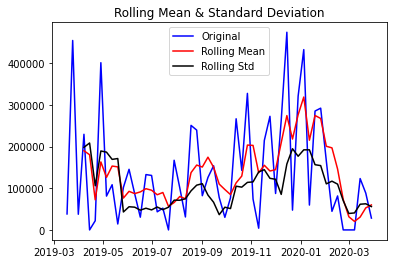

Results of Dickey-Fuller Test:
Test Statistic                 -2.617178
p-value                         0.089499
#Lags Used                      2.000000
Number of Observations Used    52.000000
Critical Value (1%)            -3.562879
Critical Value (5%)            -2.918973
Critical Value (10%)           -2.597393
dtype: float64


In [ ]:
# Testing the stationarity of our timeseries
test_stationarity(ts)

If p > .10 → “not significant”

If p ≤ .10 → “marginally significant”

If p ≤ .05 → “significant”

If p ≤ .01 → “highly significant.

Test Statistics> critical values i. e. we do not reject the null hypothesis. And the time series is not stationary

It means our timeseries has trend and seasionality.

Lower values of P are preferred


In [ ]:
ts

repayment_date
2019-03-17     38314
2019-03-24    454351
2019-03-31     37547
2019-04-07    229361
2019-04-14         0
2019-04-21     22005
2019-04-28    401079
2019-05-05     81112
2019-05-12    108412
2019-05-19     14243
2019-05-26    101993
2019-06-02    145366
2019-06-09     86832
2019-06-16     30539
2019-06-23    132726
2019-06-30    130653
2019-07-07     43426
2019-07-14     52196
2019-07-21         0
2019-07-28    167063
2019-08-04    100953
2019-08-11     31069
2019-08-18    250689
2019-08-25    239422
2019-09-01     82033
2019-09-08    125842
2019-09-15    153852
2019-09-22     77555
2019-09-29     30184
2019-10-06     77192
2019-10-13    266564
2019-10-20    142791
2019-10-27    327466
2019-11-03     74022
2019-11-10      4098
2019-11-17    214529
2019-11-24    272481
2019-12-01     87372
2019-12-08    262992
2019-12-15    474122
2019-12-22     47438
2019-12-29    320863
2020-01-05    432477
2020-01-12     59583
2020-01-19    285130
2020-01-26    292039
2020-02-02    16561

In [ ]:
# adding this fraction to remove didvide by zero while doing log transformation
ts= ts+0.000000000000001

In [ ]:
ts

repayment_date
2019-03-17    3.831400e+04
2019-03-24    4.543510e+05
2019-03-31    3.754700e+04
2019-04-07    2.293610e+05
2019-04-14    1.000000e-15
2019-04-21    2.200500e+04
2019-04-28    4.010790e+05
2019-05-05    8.111200e+04
2019-05-12    1.084120e+05
2019-05-19    1.424300e+04
2019-05-26    1.019930e+05
2019-06-02    1.453660e+05
2019-06-09    8.683200e+04
2019-06-16    3.053900e+04
2019-06-23    1.327260e+05
2019-06-30    1.306530e+05
2019-07-07    4.342600e+04
2019-07-14    5.219600e+04
2019-07-21    1.000000e-15
2019-07-28    1.670630e+05
2019-08-04    1.009530e+05
2019-08-11    3.106900e+04
2019-08-18    2.506890e+05
2019-08-25    2.394220e+05
2019-09-01    8.203300e+04
2019-09-08    1.258420e+05
2019-09-15    1.538520e+05
2019-09-22    7.755500e+04
2019-09-29    3.018400e+04
2019-10-06    7.719200e+04
2019-10-13    2.665640e+05
2019-10-20    1.427910e+05
2019-10-27    3.274660e+05
2019-11-03    7.402200e+04
2019-11-10    4.098000e+03
2019-11-17    2.145290e+05
2019-11-24   

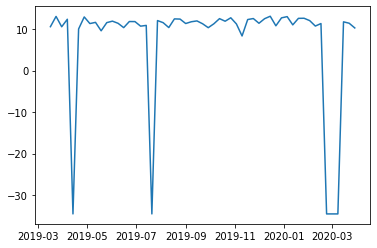

In [ ]:
#applying log transformation to reduce the trend by penalizing higher values
ts_log = np.log(ts)
plt.plot(ts_log)

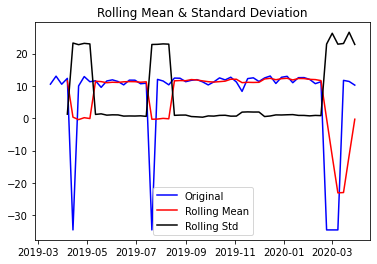

Results of Dickey-Fuller Test:
Test Statistic                 -5.051192
p-value                         0.000018
#Lags Used                      0.000000
Number of Observations Used    54.000000
Critical Value (1%)            -3.557709
Critical Value (5%)            -2.916770
Critical Value (10%)           -2.596222
dtype: float64


In [ ]:
test_stationarity(ts_log)

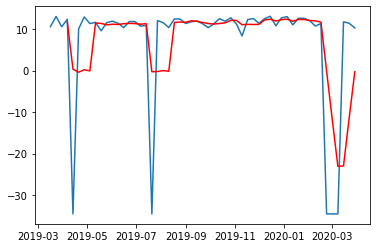

In [ ]:
#applying smoothening to calculate noise
moving_avg = ts_log.rolling(4).mean()
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

In [ ]:
#subtracting that term from the time_Series to further reduce noise
ts_log_moving_avg_diff = ts_log - moving_avg

# Since we are taking average for first 4 weeks, rolling mean is not defined for first 3 weeks
ts_log_moving_avg_diff.head(5)

repayment_date
2019-03-17          NaN
2019-03-24          NaN
2019-03-31          NaN
2019-04-07     0.728903
2019-04-14   -34.879839
Freq: W-SUN, Name: total_amount, dtype: float64

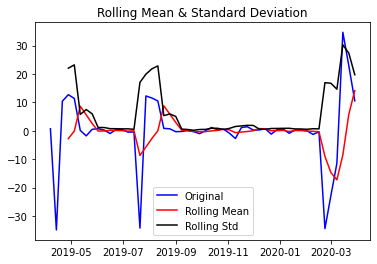

Results of Dickey-Fuller Test:
Test Statistic                -6.117284e+00
p-value                        9.030626e-08
#Lags Used                     2.000000e+00
Number of Observations Used    4.900000e+01
Critical Value (1%)           -3.571472e+00
Critical Value (5%)           -2.922629e+00
Critical Value (10%)          -2.599336e+00
dtype: float64


In [ ]:
# dropping the first three NAN values and then plotting the graph for checking stationarity
ts_log_moving_avg_diff.dropna(inplace=True)
test_stationarity(ts_log_moving_avg_diff)

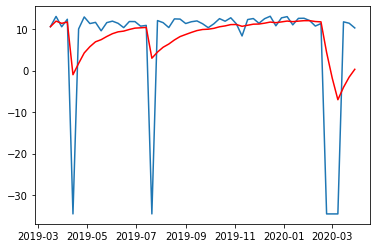

In [ ]:
# applying exponentially weighted moving average to the log series to calculate noise
expwighted_avg = ts_log.ewm(halflife=4).mean()
plt.plot(ts_log)
plt.plot(expwighted_avg, color='red')

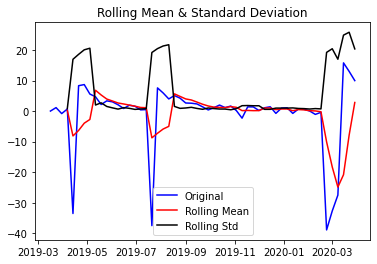

Results of Dickey-Fuller Test:
Test Statistic                 -4.617395
p-value                         0.000120
#Lags Used                      2.000000
Number of Observations Used    52.000000
Critical Value (1%)            -3.562879
Critical Value (5%)            -2.918973
Critical Value (10%)           -2.597393
dtype: float64


In [ ]:
# substracting it from the series to reduce noise
ts_log_ewma_diff = ts_log - expwighted_avg
test_stationarity(ts_log_ewma_diff)

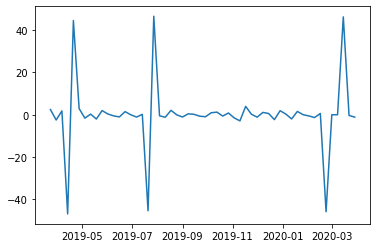

In [ ]:
# using first order differencing to eliminate trend and seasionality or to improve stationarity
ts_log_diff = ts_log - ts_log.shift()
plt.plot(ts_log_diff)

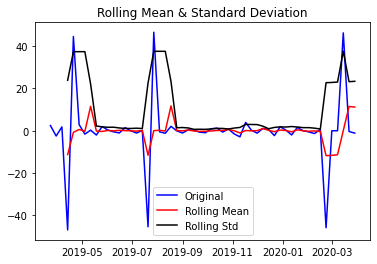

Results of Dickey-Fuller Test:
Test Statistic                 -4.789428
p-value                         0.000057
#Lags Used                      4.000000
Number of Observations Used    49.000000
Critical Value (1%)            -3.571472
Critical Value (5%)            -2.922629
Critical Value (10%)           -2.599336
dtype: float64


In [ ]:
# applying Dickey Fuller Test to check for stationarity
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)